In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [2]:
wf = np.loadtxt('emi/calibrator_231001.txt')[:,1]
emi = np.loadtxt('emi/pre12ppre0001mb0r0x1fa0g0_mono_0000_a_ch3.dat',skiprows=5)[:-1]

In [3]:
## first fold emi over full cycle
emi_folded = emi.reshape((8,2048)).mean(axis=0)

In [4]:
## now get the response, approximately
emi_pk = np.abs(np.fft.rfft(emi_folded)**2)
wf_f = np.fft.rfft(wf)
wf_pk = np.abs(wf_f**2)

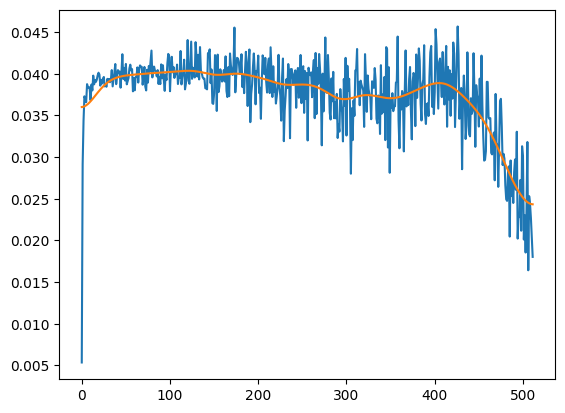

In [5]:
rat = emi_pk[1::2]/wf_pk[1::2]
rats = gaussian_filter(rat,15)
plt.plot(rat)
plt.plot(rats)

Nover = 32
def get_norm_wf(prat, oversample = 16):
    wf_f = np.fft.rfft(wf)
    wf_f[1::2]*=np.sqrt(prat)
    if oversample>1:
        wf_fx = np.zeros((len(wf_f)-1)*oversample+1,complex)
        wf_fx [:len(wf_f)]=wf_f*oversample
        return np.fft.irfft(wf_fx)
    return np.fft.irfft(wf_f)
wf_norm = get_norm_wf(rat,Nover)
wf_unnorm = get_norm_wf(1,Nover)

In [6]:
# now setup and predictor
y = np.hstack([wf_norm]*10)
x = np.arange(2048*10*Nover)/Nover
predictor = interp1d (x,y)
def pred (ofs, A,alpha):
    return predictor (np.arange(16384)*(1+alpha)+ofs)*(1+A)
def chi2 (ofs,A, alpha):
    t = pred(ofs, A,alpha)
    return ((t-emi)**2).sum()

In [7]:
# first find the coarse offset
o = [chi2(ofs, 0,0) for ofs in np.arange(2048)]
io = np.array(o).argmin()

In [8]:
res=minimize(lambda x: chi2(*x), [io, 1e-2,1e-6], method='Nelder-Mead',bounds = [(io-4,io+4),(-0.3,0.3),(-1e-3, 1e-3)], tol=1e-6)

In [9]:
print (res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2823802505.8990784
             x: [ 1.727e+03 -1.165e-02 -1.312e-05]
           nit: 264
          nfev: 516
 final_simplex: (array([[ 1.727e+03, -1.165e-02, -1.312e-05],
                       [ 1.727e+03, -1.165e-02, -1.312e-05],
                       [ 1.727e+03, -1.165e-02, -1.312e-05],
                       [ 1.727e+03, -1.165e-02, -1.312e-05]]), array([ 2.824e+09,  2.824e+09,  2.824e+09,  2.824e+09]))


In [10]:
thf = pred(*res.x)

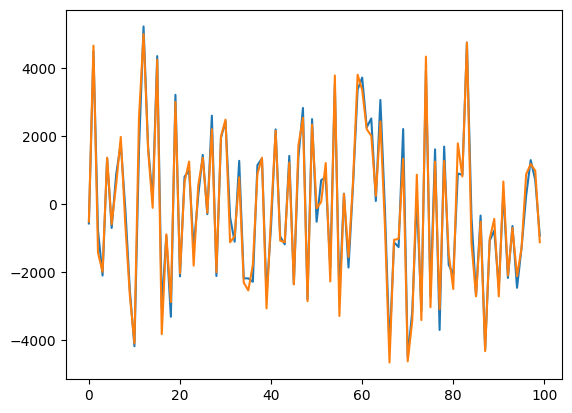

In [11]:
plt.plot(thf[-100:])
plt.plot(emi[-100:])

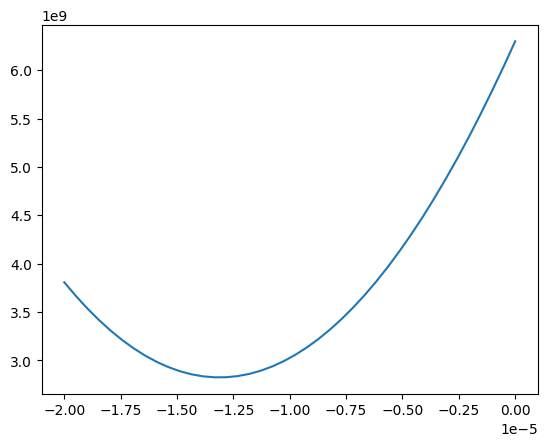

In [12]:
clka = np.linspace (-2e-5, 0e-5, 40)
plt.plot(clka, [chi2(res.x[0], res.x[1], clk) for clk in clka])

In [13]:
(thf-emi).var()/emi.var()

0.03598551869219667

[]

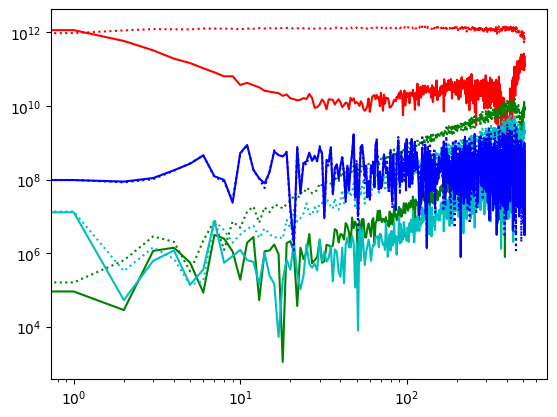

In [14]:
emif_pk = np.abs(np.fft.rfft(emi)**2)
res_pk = np.abs(np.fft.rfft(thf-emi)**2)
plt.plot(emif_pk[8::16],'r:')
plt.plot(res_pk[8::16],'r-')

plt.plot(emif_pk[9::16],'g:')
plt.plot(res_pk[9::16],'g-')

plt.plot(emif_pk[10::16],'c:')
plt.plot(res_pk[10::16],'c-')

plt.plot(emif_pk[16::16],'b:')
plt.plot(res_pk[16::16],'b-')
#plt.semilogy()
plt.loglog()


[]

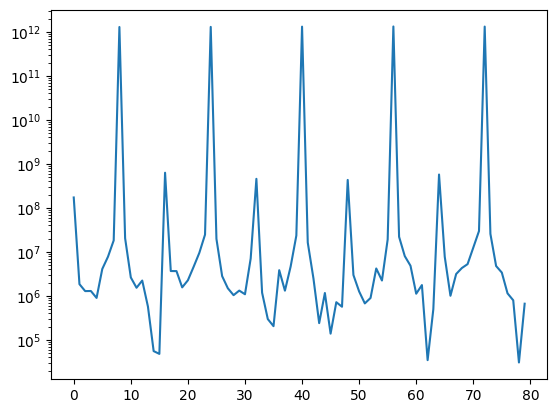

In [15]:
plt.plot(emif_pk[256:256+5*16])
plt.semilogy()

In [16]:
y = np.hstack([wf_unnorm]*10)
x = np.arange(2048*10*Nover)/Nover
ofs, A,alpha = res.x
unnorm_pred = interp1d (x,y)(np.arange(16384)*(1+alpha)+ofs)*(1+A)
unnorm_pred *= thf.std()/unnorm_pred.std()

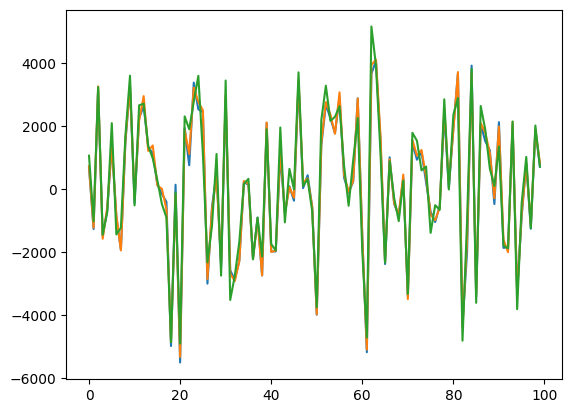

In [17]:
plt.plot(unnorm_pred[0:100])
plt.plot(thf[:100])
plt.plot(emi[:100])

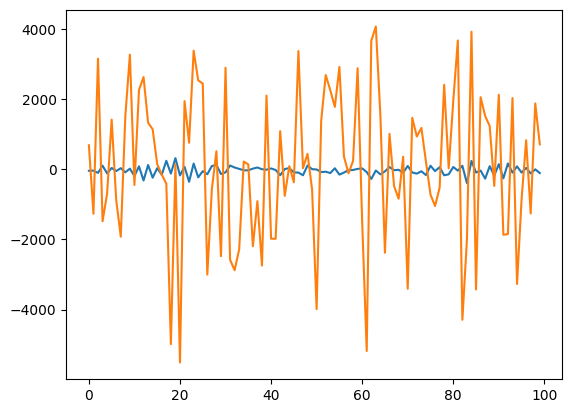

In [18]:
plt.plot((unnorm_pred-thf)[:100])
plt.plot((unnorm_pred[:100]))

In [19]:
emi_fullpk = np.abs(np.fft.rfft(emi)**2)
wf_fullpk = np.abs(np.fft.rfft(unnorm_pred)**2)

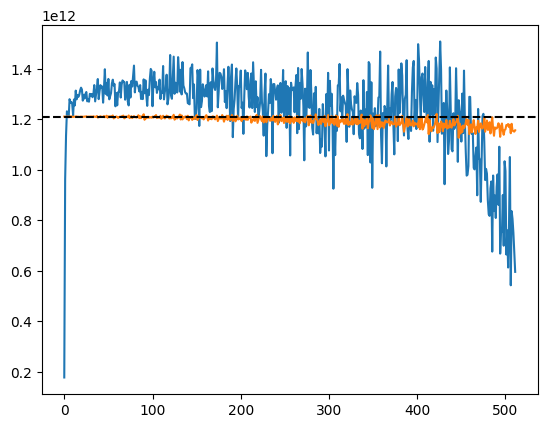

In [20]:
plt.plot(emi_fullpk[8::16])
plt.plot(wf_fullpk[8::16])
plt.axline((0,wf_fullpk[8]),slope=0,color='k', ls='--')